In [1]:
import pandas as pd
import glob
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from transformers import ViTModel, ViTConfig
from transformers import AutoModel
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

In [2]:
training = pd.read_csv('./train_data_resamples_ordered.csv')
testing = pd.read_csv('./test_data_resamples_ordered.csv')

In [3]:
PID = { 'R01-005','R01-012','R01-013','R01-014','R01-017','R01-021','R01-026','R01-027','R01-028','R01-029',
        'R01-038','R01-043','R01-046','R01-048','R01-049','R01-051','R01-052','R01-054','R01-055','R01-056',
        'R01-057','R01-059','R01-060','R01-061','R01-062','R01-063','R01-064','R01-065','R01-066','R01-067',
        'R01-068','R01-069','R01-071','R01-072','R01-073','R01-076','R01-078','R01-080','R01-081','R01-083',
        'R01-084','R01-089','R01-091','R01-093','R01-094','R01-096','R01-097','R01-098','R01-100','R01-101',
        'R01-102','R01-103','R01-104','R01-105','R01-106','R01-107','R01-108','R01-109','R01-110','R01-111',
        'R01-112','R01-113','R01-114','R01-115','R01-116','R01-117','R01-118','R01-119','R01-120','R01-121',
        'R01-122','R01-123','R01-124','R01-125','R01-126','R01-127','R01-128','R01-129','R01-130','R01-131',
        'R01-132','R01-133','R01-134','R01-135','R01-136','R01-138','R01-139','R01-140','R01-141','R01-142',
        'R01-144','R01-145','R01-146','R01-147','R01-148','R01-149','R01-151','R01-152','R01-154','R01-156',
        'R01-157','R01-158','R01-159','R01-160','LUNG-002','LUNG-004','LUNG-006','LUNG-009','LUNG-011',
        'LUNG-012','LUNG-018','LUNG-022','LUNG-030','LUNG-042','LUNG-045','LUNG-046','LUNG-047','LUNG-053',
        'LUNG-054','LUNG-061','LUNG-063','LUNG-068','LUNG-073','LUNG-078','LUNG-082','LUNG-086','LUNG-093',
        'LUNG-098','LUNG-099','LUNG-101','LUNG-104','LUNG-105','LUNG-116','LUNG-122','LUNG-135','LUNG-150',
        'LUNG-151','LUNG-173','LUNG-177','LUNG-193','LUNG-201','LUNG-202','LUNG-206','LUNG-208','LUNG-210'}

# Base directory
# Fused Scans Only
base_dir = './Fused Lung 2 copy'

# Store patient ID and corresponding image paths
image_paths_per_pid = {}

# Loop through each patient ID
for pid in PID:
    # Use glob to find all images starting with the patient ID
    image_paths = glob.glob(os.path.join(base_dir, f'{pid}*'))

    # Concatenate image paths with ";" and store in the dictionary
    image_paths_per_pid[pid] = ";".join(image_paths)

training['Images'] = training['Case ID'].map(image_paths_per_pid)
testing['Images'] = testing['Case ID'].map(image_paths_per_pid)

training['Images'] = training['Images'].str.split(';')
testing['Images'] = testing['Images'].str.split(';')
exploded_df_train = training.explode('Images')
exploded_df_test = testing.explode('Images')


In [4]:
# Define the model
class ViTFeatureExtractor(nn.Module):
    def __init__(self):
        super(ViTFeatureExtractor, self).__init__()
        self.vit = AutoModel.from_pretrained("Santipab/Braincode-BEiT-2e-5-lion-NSCLC")

    def forward(self, x):
        outputs = self.vit(pixel_values=x)
        return outputs.last_hidden_state[:, 0, :]  # Extract the [CLS] token's features
    
class TabularModel(nn.Module):
    def __init__(self, num_features):
        super(TabularModel, self).__init__()
        # Increased complexity for tabular model
        self.fc = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.InstanceNorm1d(128), 
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.InstanceNorm1d(128),  
            nn.Dropout(0.5),
            nn.Linear(64, 32)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

class FusionModel(nn.Module):
    def __init__(self, num_tabular_features):
        super(FusionModel, self).__init__()
        self.vit_feature_extractor = ViTFeatureExtractor()
        self.tabular_model = TabularModel(num_tabular_features)
        self.classifier = nn.Linear(768 + 32, 2)

    def forward(self, images, tabular_data):
        image_features = self.vit_feature_extractor(images)
        tabular_features = self.tabular_model(tabular_data)
        combined = torch.cat((image_features, tabular_features), dim=1)
        output = self.classifier(combined)
        return output
    
    def forward_image_only(self, images):
        image_features = self.vit_feature_extractor(images)
        return image_features


In [5]:
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, image_paths, labels, transform=None):
        self.dataframe = dataframe
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Load image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Load tabular data
        tabular_data = torch.tensor(self.dataframe.iloc[idx, :].values, dtype=torch.float32)

        # Load label
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return image, tabular_data, label

In [6]:
def train(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, tabular_data, labels in train_loader:
            images = images.to(device)
            tabular_data = tabular_data.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, tabular_data)
            loss = criterion(outputs, labels)
            loss.backward()

            # Implement gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        scheduler.step()  # Adjust the learning rate
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


def test(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, tabular_data, labels in data_loader:
            images = images.to(device)
            tabular_data = tabular_data.to(device)
            labels = labels.to(device)
            outputs = model(images, tabular_data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [7]:
num_tabular_features = 51
num_classes = 2
model = FusionModel(num_tabular_features)
device = "mps" if torch.backends.mps.is_available() else "cpu"
model.to(device)

# Example DataFrame and image paths (replace with your actual data)
dataframe = exploded_df_train.drop(['Case ID', 'Histology' ,'Images'], axis=1)
#convert column to list
image_paths = exploded_df_train['Images'].tolist()
labels = exploded_df_train['Histology'].tolist() 

dataframe_test = exploded_df_test.drop(['Case ID', 'Histology' ,'Images'], axis=1)
#convert column to list
image_paths_test = exploded_df_test['Images'].tolist()
labels_test = exploded_df_test['Histology'].tolist()

# Define transformations for the images
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create dataset and data loader
dataset = CustomDataset(dataframe, image_paths, labels, transform=train_transform)
test_dataset = CustomDataset(dataframe_test, image_paths_test, labels_test, transform=test_transform)

batch_size = 64
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train and test the model
train(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs = 5)

Some weights of the model checkpoint at Santipab/Braincode-BEiT-2e-5-lion-NSCLC were not used when initializing BeitModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BeitModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BeitModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BeitModel were not initialized from the model checkpoint at Santipab/Braincode-BEiT-2e-5-lion-NSCLC and are newly initialized: ['beit.encoder.layer.3.attention.attention.relative_position_bias.relative_position_index', 'beit.encoder.layer.10.attention.attention.relative_position_bias.relative_position_index', 'beit.encoder.layer.9.attention.attention.relative_posit

Epoch 1/5, Loss: 3.1187, Accuracy: 74.63%
Epoch 2/5, Loss: 0.1275, Accuracy: 97.75%
Epoch 3/5, Loss: 0.0064, Accuracy: 99.84%
Epoch 4/5, Loss: 0.0031, Accuracy: 99.89%
Epoch 5/5, Loss: 0.0014, Accuracy: 99.93%


### Hyperparameter Fine-tuning 

In [ ]:
# Hyperparameter Grid
learning_rates = [0.001, 1e-4, 1e-5]
batch_sizes = [64, 96]
epoch_options = [5]

best_accuracy = 0
best_hyperparams = { 
    'learning_rate': None,
    'batch_size': None,
    'epochs': None
}

for lr in learning_rates:
    for batch_size in batch_sizes:
        for epochs in epoch_options:
            print(f"Training with learning rate: {lr}, batch size: {batch_size}, epochs: {epochs}")

            # Initialize model, criterion, optimizer, scheduler
            model = FusionModel(num_tabular_features).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

            # Create data loaders
            train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size)

            # Train the model
            train(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=epochs)
            
            # Evaluate the model
            test_accuracy = test(model, test_loader)

            # Update best model if current model is better
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                best_hyperparams['learning_rate'] = lr
                best_hyperparams['batch_size'] = batch_size
                best_hyperparams['epochs'] = epochs

print(f"Best Hyperparameters: {best_hyperparams}, Best Accuracy: {best_accuracy}")

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from transformers import AutoModel


def train_and_evaluate(params):
    global best
    # Create model with hyperparameters
    model = FusionModel(num_tabular_features)
    model.to(device)

    dataframe = exploded_df_train.drop(['Images', 'Case ID', 'Histology'], axis=1)
    #convert column to list
    image_paths = exploded_df_train['Images'].tolist()
    labels = exploded_df_train['Histology'].tolist() 

    dataframe_test = exploded_df_test.drop(['Images', 'Case ID', 'Histology'], axis=1)
    #convert column to list
    image_paths_test = exploded_df_test['Images'].tolist()
    labels_test = exploded_df_test['Histology'].tolist()

    # Define transformations for the images
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor()
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    # Dataset and DataLoader
    train_dataset = CustomDataset(dataframe, image_paths, labels, transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=int(params['batch_size']), shuffle=True)
    test_dataset = CustomDataset(dataframe_test, image_paths_test, labels_test, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=int(params['batch_size']))
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

    # Training loop (similar to your train function)
    for epoch in range(params['epochs']):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, tabular_data, labels in train_loader:
            images = images.to(device)
            tabular_data = tabular_data.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, tabular_data)
            loss = criterion(outputs, labels)
            loss.backward()

            # Implement gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}/{params['epochs']}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

        # Test after each epoch
        test_accuracy = test(model, test_loader)
        print(f'Test Accuracy after epoch {epoch + 1}: {test_accuracy:.2f}%')


        if test_accuracy > best:
            best = test_accuracy
            print(f'Performance condition satisfied, saving training after epoch {epoch + 1}')
            torch.save(model.state_dict(), './Multimodal_v3_weights_' + str(test_accuracy) +'.pth')
            torch.save(model, './Multimodal_v3' + str(test_accuracy) + '.pth')

    # Evaluation (similar to your test function)
    accuracy = test(model, test_loader)  # Use your test function here

    return {'loss': -accuracy, 'status': STATUS_OK}  # Negative accuracy because fmin() minimizes the objective

space = {
    'lr': hp.uniform('lr', 0.001, 0.01),
    'batch_size': hp.choice('batch_size', [64]),
    'epochs': hp.choice('epochs', [10])
}

# Run the hyperparameter search using the tpe algorithm
trials = Trials()

best = fmin(
    fn=train_and_evaluate,
    space=space,
    algo=tpe.suggest,
    max_evals=20, 
    trials=Trials()
)

print(f"Best hyperparameters: {best}")


In [ ]:
torch.save(model.state_dict(), './Multimodal_BEiT_Fused_94_weights.pth')
torch.save(model, './Multimodal_BEiT_Fused_94.pth')

In [9]:
model = torch.load('./Multimodal_BEiT_Fused_94.pth')

/Users/salma/anaconda3/envs/tensor/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


[[896   0]
 [101 699]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       896
           1       1.00      0.87      0.93       800

    accuracy                           0.94      1696
   macro avg       0.95      0.94      0.94      1696
weighted avg       0.95      0.94      0.94      1696



<Axes: >

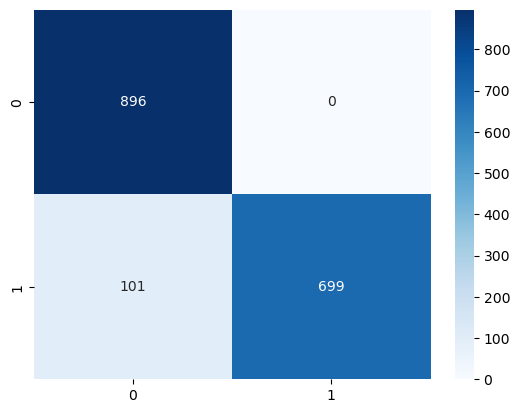

In [11]:
model.eval()
correct = 0
total = 0
all_predicted = []
all_labels = []
with torch.no_grad():
    for image, tabular_data, labels in test_loader:
        image = image.to(device)
        tabular_data = tabular_data.to(device)
        labels = labels.to(device)
        all_labels.append(labels)
        outputs = model(image, tabular_data)
        _, predicted = torch.max(outputs.data, 1)
        all_predicted.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

#confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_true = torch.cat(all_labels)
y_pred = torch.cat(all_predicted)
print(confusion_matrix(y_true.cpu(), y_pred.cpu()))
print(classification_report(y_true.cpu(), y_pred.cpu()))
sns.heatmap(confusion_matrix(y_true.cpu(), y_pred.cpu()), annot=True, fmt='g', cmap='Blues')